In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import log_loss, confusion_matrix
from scipy.special import expit
from xgboost import XGBRegressor, XGBClassifier
from xgboost.sklearn import XGBModel

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
from trust_pbm import TrustPBM


## Load data

In [2]:
df = pd.read_pickle('../data/_raw_20191201_20191202.pkl')
df['serie_order_line'] = (df.serie_order - 1)//3 + 1
len(df), df[df.label>0].groupby(['user_id', 'session_start','collection']).size().multiply(
    df.groupby(['user_id', 'session_start','collection']).size()
).sum(), (df.label > 0).sum()

(255899, 665996, 73769)

## Generate single_click_mode for single_click_mode data

In [3]:
df = df[df.label > 0][['user_id', 'session_start','collection', 'serie', 'label']]\
.merge(df,on=['user_id', 'session_start','collection'], suffixes=('_c', ''))
len(df)

665996

In [4]:
df.loc[df.serie_c != df.serie,'label'] = 0
(df.label > 0).sum()

73769

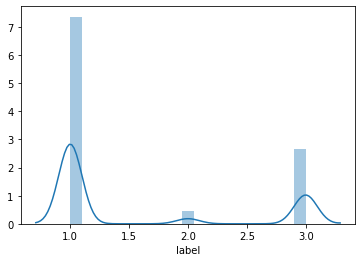

In [5]:
sns.distplot(df.label[df.label > 0])

## Extract X

In [6]:
X_columns = np.concatenate([
    [f'user_latent_{i}' for i in range(50)],
    [f'user_history_short_latent_{i}' for i in range(50)],
    [f'user_history_long_latent_{i}' for i in range(50)],
    [f'user_audiences_users_latent_{i}' for i in range(50)],
    [f'user_audiences_genres_latent_{i}' for i in range(50)],
    [f'collection_genres_latent_{i}' for i in range(50)],
    [f'collection_series_latent_{i}' for i in range(50)],
    [f'serie_latent_{i}' for i in range(50)],
    ['user_serie_history']
])
X = df[X_columns]
X = X.fillna(0).values

X_k = df.serie_order_line.values
X_c = (df.label.values > 0).astype(int)

theta0 = 1/np.arange(1, X_k.max()+1)

## Init gamma

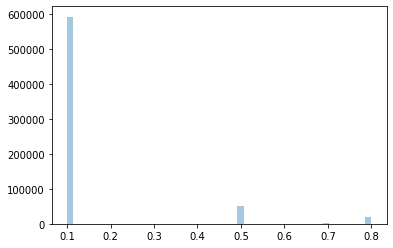

In [7]:
c_to_gamma = np.array([0.1, 0.5, 0.7, 0.8])
gamma0 = c_to_gamma.take(df.label.values)
sns.distplot(gamma0, kde=False)

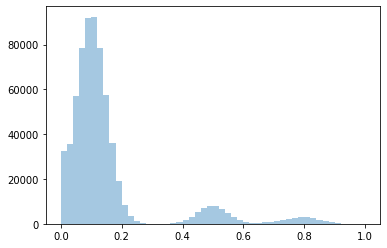

In [8]:
gamma0 = np.clip(gamma0 + np.random.normal(0, 0.05, gamma0.shape), 0, 1)
sns.distplot(gamma0, kde=False)

## Init ep_plus and ep_minus

In [9]:
ep_plus0 = np.full(theta0.shape, 0.5)
ep_minus0 = np.full(theta0.shape, 0.5)

## Clean and train

In [10]:
del df

reg = TrustPBM(
    max_iter=100,
    n_estimators=100,
    n_iter_no_change=5,
    verbose='debug',
    gpu=True,
)

reg.fit(
    X=X,
    X_k=X_k,
    X_c=X_c,
    gamma_0=gamma0,
    theta_0=theta0,
    max_rank=1,
    ep_plus_0=ep_plus0,
    ep_minus_0=ep_minus0,
)
preds = reg.predict(X)

print(log_loss(X_c, preds))
print(confusion_matrix(X_c, np.where(preds>=0.5,1,0)))

It 0:
Fitting gbdt...
Updating theta, ep_plus, ep_minus...
Updating gamma...
Loss: 0.23738648034107473
no_improvement_count = 0
It 1:
Fitting gbdt...
Updating theta, ep_plus, ep_minus...
Updating gamma...
Loss: 0.042369647270363436
no_improvement_count = 0
It 2:
Fitting gbdt...
Updating theta, ep_plus, ep_minus...
Updating gamma...
Loss: 0.03365217360535173
no_improvement_count = 0
It 3:
Fitting gbdt...
Updating theta, ep_plus, ep_minus...
Updating gamma...
Loss: 0.030591856456073697
no_improvement_count = 0
It 4:
Fitting gbdt...
Updating theta, ep_plus, ep_minus...
Updating gamma...
Loss: 0.028972471859194656
no_improvement_count = 0
It 5:
Fitting gbdt...
Updating theta, ep_plus, ep_minus...
Updating gamma...
Loss: 0.027834197047829582
no_improvement_count = 0
It 6:
Fitting gbdt...
Updating theta, ep_plus, ep_minus...
Updating gamma...
Loss: 0.02694632913350795
no_improvement_count = 0
It 7:
Fitting gbdt...
Updating theta, ep_plus, ep_minus...
Updating gamma...
Loss: 0.026172291385306

/home/nabdev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/nabdev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Loss: nan
no_improvement_count = 0
It 34:
Fitting gbdt...


KeyboardInterrupt: 

In [11]:
for split in np.arange(0.3,0.7,0.1):
    print(f'Split at {split}')
    print(confusion_matrix(X_c, np.where(preds>=split,1,0)))
print(f'Split at {preds.mean()}')
print(confusion_matrix(X_c, np.where(preds>=preds.mean(),1,0)))

Split at 0.3


NameError: name 'preds' is not defined

In [ ]:
sns.distplot(preds)

In [12]:
thetas, ep_pluses_, ep_minuses_, losses = reg.thetas_, reg.ep_pluses_, reg.ep_minuses_, reg.losses_

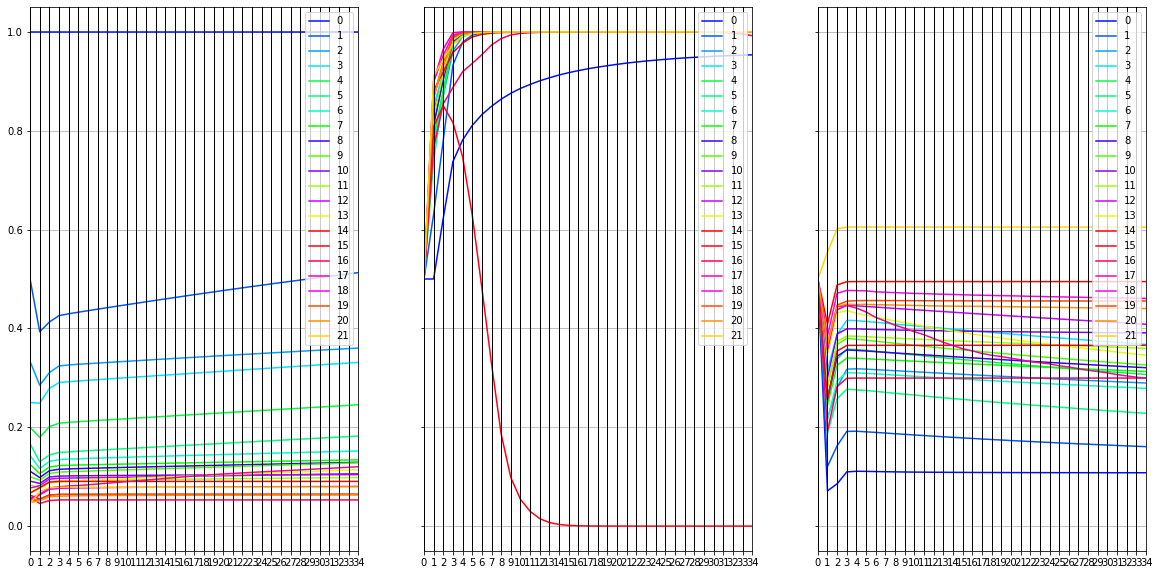

In [13]:
f, a = plt.subplots(1,3, figsize=(20,10), sharey=True)
pd.plotting.parallel_coordinates(
    pd.DataFrame(np.array(thetas).T).reset_index(), 
    'index',
    sort_labels=True,
    colormap='hsv',
    ax=a[0]
)
pd.plotting.parallel_coordinates(
    pd.DataFrame(np.array(ep_pluses_).T).reset_index(), 
    'index',
    sort_labels=True,
    colormap='hsv',
    ax=a[1]
)
pd.plotting.parallel_coordinates(
    pd.DataFrame(np.array(ep_minuses_).T).reset_index(), 
    'index',
    sort_labels=True,
    colormap='hsv',
    ax=a[2]
)

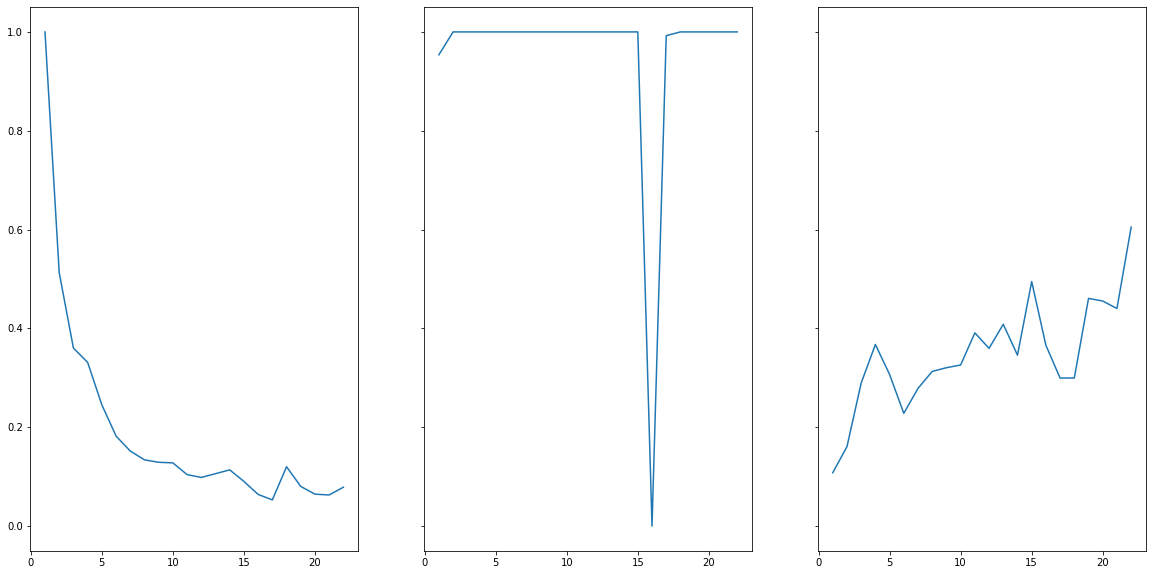

In [14]:
f, a = plt.subplots(1,3, figsize=(20,10), sharey=True)
sns.lineplot(
    x = list(range(1,len(thetas[-1])+1)),
    y = thetas[-1],
    ax=a[0]
)
sns.lineplot(
    x = list(range(1,len(ep_pluses_[-1])+1)),
    y = ep_pluses_[-1],
    ax=a[1]
)
sns.lineplot(
    x = list(range(1,len(ep_minuses_[-1])+1)),
    y = ep_minuses_[-1],
    ax=a[2]
)

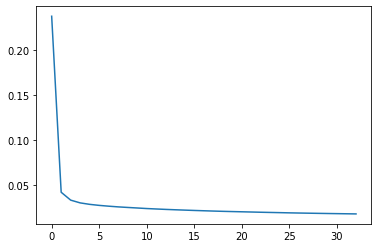

In [15]:
ax = sns.lineplot(
    x=range(len(losses)),
    y=losses
)
# ax.set(ylim=(0,1))

In [16]:
reg.gbdt_.get_booster().feature_names = X_columns.tolist()

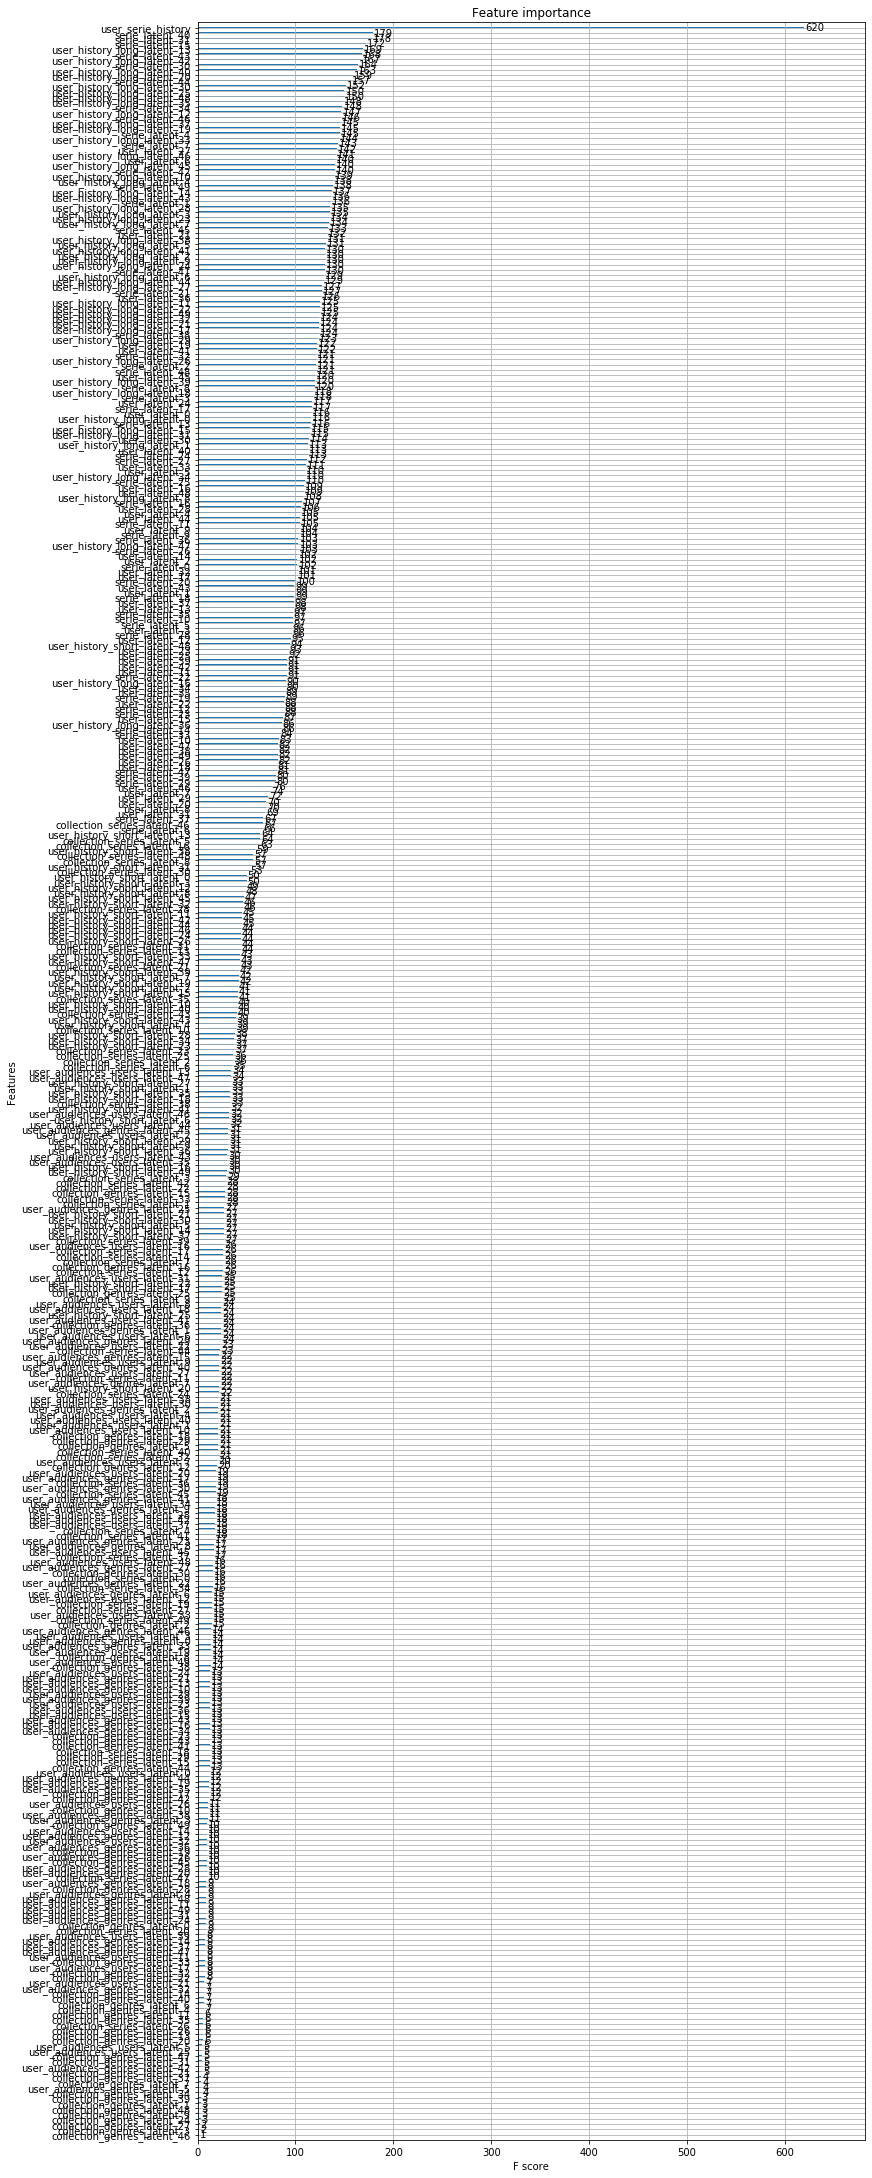

In [17]:
fig, axes = plt.subplots(1,1, figsize=(10,30))
fig.tight_layout()
xgb.plot_importance(reg.gbdt_.get_booster(),  ax=axes)

In [72]:
valpath = '../data/_multi_outlier_removed_20191201_20191207.svmlight'
dval = xgb.DMatrix(f"{valpath}#{valpath}.cache", feature_names=X_columns)

[07:14:36] 940046x401 matrix with 319159088 entries loaded from ../data/_multi_outlier_removed_20191201_20191207.svmlight#../data/_multi_outlier_removed_20191201_20191207.svmlight.cache


In [75]:
preds = reg.gbdt_.get_booster().predict(dval)

In [77]:
from _svmlight_format_io import load_query_id
qid_val = load_query_id(valpath)

In [78]:
y_val = dval.get_label()

In [90]:
from rank_metrics import ndcg_score, mean_average_precision_score

In [88]:
ndcg_val = ndcg_score(y_val, preds, qid_val, verbose=0)
ndcg_val

0.7436155969860383